In [18]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch
from sklearn.metrics import mean_squared_error
from scipy.stats.mstats import gmean

In [19]:
weights = json.load(open('../Downloads/out_weights.json'))

In [20]:
def read_df(path, embeddings_path=None):
    # Read csv
    df = pd.read_csv(path)
    
    # Append filename and source_file column column
    filenames = []
    for i in df["id"]:
        nmb = i.split('_')[-1]
        filenames.append(i[:-len(nmb)-1])
    df["file_name"] = filenames
    filenames = list(set(filenames))
    df['source_file'] = df["file_name"].apply(lambda x: int(x[:3]))
    # Append embeddings
    if embeddings_path != None:
        embedding_df = pd.read_csv(embeddings_path)
        embedding_df['source_file'] = embedding_df['fname']
        embedding_df['embeddings'] = embedding_df['embeddings'].apply(lambda x: np.array([*map(float, x.strip('][').replace("'","").split(','))]))
        df = pd.merge(df, embedding_df).drop(columns=["fname"])
    # Calculate miss ratios into a seperate dataframe
    miss_ratios = pd.DataFrame()
    for i in ["768", "1024", "1536", "2048", "3072","4096", "6144", "8192"]:
        miss_ratios[i] = df['misses_'+i] / df['accesses_'+i]
        miss_ratios['misses_'+i] = df['misses_'+i] 
        miss_ratios['accesses_'+i] = df['accesses_'+i] 
        df = df.drop(columns=['misses_'+i, 'accesses_'+i])
        if 'l1d_accesses_'+i in df.columns:
            df = df.drop(columns=['l1d_accesses_'+i])
    return df, miss_ratios
rds, mrs = read_df('../ce_data/output_512/dataset_lru_extra.csv', '../ce_data/embeddings/flow-aware-f.csv')
mrs.head()

,768,misses_768,accesses_768,1024,misses_1024,accesses_1024,1536,misses_1536,accesses_1536,2048,...,accesses_3072,4096,misses_4096,accesses_4096,6144,misses_6144,accesses_6144,8192,misses_8192,accesses_8192
0,0.922884,488872.0,529722.0,0.891123,472049.0,529724.0,0.837276,443527.0,529726.0,0.795601,...,529724.0,0.662782,351091.0,529723.0,0.316790,167812.0,529726.0,0.123358,65346.0,529725.0
1,0.904695,478790.0,529228.0,0.866846,458759.0,529228.0,0.806762,426960.0,529227.0,0.765354,...,529233.0,0.660919,349781.0,529234.0,0.313406,165865.0,529233.0,0.077643,41091.0,529231.0
2,0.891399,474718.0,532554.0,0.848553,451901.0,532555.0,0.780124,415463.0,532560.0,0.727294,...,532550.0,0.641544,341654.0,532550.0,0.422281,224886.0,532551.0,0.262694,139898.0,532551.0
3,0.779165,408753.0,524604.0,0.622860,326738.0,524577.0,0.393169,206253.0,524591.0,0.225061,...,524588.0,0.040571,21285.0,524640.0,0.010514,5516.0,524646.0,0.001862,977.0,524647.0
4,0.736507,409659.0,556219.0,0.588169,327151.0,556219.0,0.375685,208962.0,556216.0,0.200199,...,556252.0,0.032464,18058.0,556253.0,0.007372,4101.0,556262.0,0.001848,1028.0,556263.0


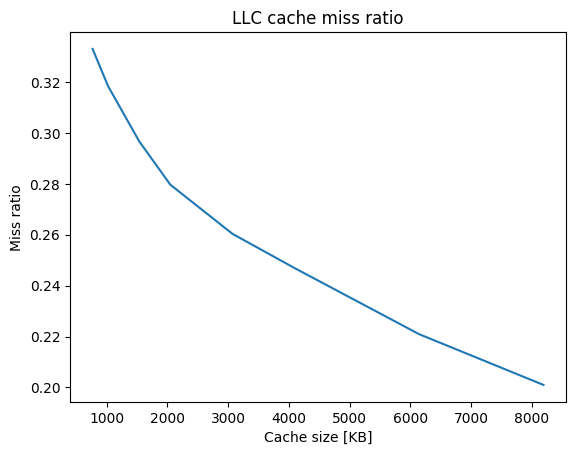

In [21]:
def a(x):
    return x/x.sum()

cs = ['768', '1024', '1536', '2048', '3072', '4096', '6144', '8192']
mcs = ['misses_'+i for i in cs]
acs = ['accesses_'+i for i in cs]
mrs2 = mrs.copy()
mrs2['fname'] = rds['file_name']
means = mrs2.groupby('fname').mean()
#print(means.index)
means['asp'] = [x.split('-')[0] for x in means.index]
#print(means)
means['weights'] = [float(weights[x]) for x in means.index]
#print(means)
d = means.groupby('asp')['weights'].apply(a)
#print(means)
# print(d.to_frame().droplevel(0))
# d = d.to_list()
# print(d)
# print(d.fname == means.fname)
means['weights'] = d.to_frame().droplevel(0)
# print(means)
for j in cs: 
    means[j] = means[j] * means['weights']
means = means.groupby('asp')[cs].mean()
plt.figure()
plt.plot([768, 1024, 1536, 2048, 3072, 4096, 6144, 8192], means[cs].mean())
# plt.plot([768, 1024, 1536, 2048, 3072, 4096, 6144, 8192], means[cs].max())
# plt.plot([768, 1024, 1536, 2048, 3072, 4096, 6144, 8192], means[cs].min())
plt.title("LLC cache miss ratio")
plt.ylabel("Miss ratio")
plt.xlabel("Cache size [KB]")
plt.savefig(f'../Documents/nn_figures/miss_ratio.png')
plt.show()


In [22]:
def read_files(pred_path, test_path, col_path, plot=True):
    x = np.load(pred_path)
    y = np.load(test_path)
    # print(mean_squared_error(x,y), x.shape)
    ids = np.load(col_path, allow_pickle=True)
    ids = pd.DataFrame(ids)
    ids = ids.rename(columns={0: "file_name"})

    for i,j in enumerate(['1024', '2048', '4096', '8192']):
        ids[j + "_x"] = x[:,i]
        ids[j + "_y"] = y[:,i]
        ids[j] = (x[:,i] - y[:,i])
        ids[j+'_abs'] = ids[j].abs()
        heatmap, xedges, yedges = np.histogram2d(x[:,i], y[:,i], bins=20)
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        if plot:
            plt.clf()
            plt.imshow(heatmap.T, extent=extent, origin='lower')
            plt.colorbar()
            plt.title(j+' cache misses')
            plt.xlabel('Predicted cache misses')
            plt.ylabel('Actual cache misses')
            plt.savefig(f'../Documents/nn_figures/{fname}_{net}_heat_{j}.png')
            plt.show()
    return ids
net = "lstm"
fname = "lru"
ids = read_files(f'../Documents/nn_outputs2/{fname}_{net}_full4.npy',
                         f'../Documents/nn_outputs2/{fname}_y_test_{net}_full4.npy', 
                         f'../Documents/nn_outputs2/{fname}_names_{net}_full4.npy', plot=False)

print(ids[ids['file_name'] == '416.gamess-875B'])


           file_name   1024_x    1024_y      1024  1024_abs    2048_x  \
246  416.gamess-875B  0.82596  0.255519  0.570441  0.570441  0.550002   

      2048_y      2048  2048_abs    4096_x   4096_y     4096  4096_abs  \
246  0.25506  0.294942  0.294942  0.552331  0.25506  0.29727   0.29727   

       8192_x   8192_y      8192  8192_abs  
246  0.519199  0.25506  0.264138  0.264138  


In [23]:
def create_plots(ids, fname, net, plot = True):
    tmp = []
    mean_df = pd.DataFrame()
    print(f"{fname}, cache sizes {['1024', '2048', '4096', '8192']}:")
    for i in ['1024', '2048', '4096', '8192']:
        means = ids.groupby('file_name')[i].mean().to_frame()
        means['asp'] = [x.split('-')[0] for x in means.index]
        means['weights'] = [float(weights[x]) for x in means.index]
        means['weights'] = means.groupby('asp')['weights'].apply(lambda x: x / x.sum()).to_frame().droplevel(0)
        means[i] = means[i] * means['weights']
#         print(means)
        means = means.groupby('asp')[i].mean() # .apply(gmean) # apply(lambda x: x.max() - x.min())
#         worst = means.nlargest(3)
#         print('Largest errors:', worst)
        means = means.abs()
        print(f"{gmean(means)*100:.1f}\\% & ",end="")
#         print(i, gmean(means.abs()))
        tmp.append(means.abs() * 100)
        mean_df[i] = means
        if plot:
            plt.figure()
            plt.hist(means.abs(), np.linspace(0,1.0,101))
    #         plt.yticks([*range(0,int(plt.yticks()[0][-1]))])
            plt.title(f'Histogram of predictions, {i}KB cache')
            plt.ylabel('# benchmarks')
            plt.xlabel('Error')
            plt.savefig(f'../Documents/nn_figures/{fname}_{net}_hist_{i}.png')
            plt.show()
    print()
    if plot:
        plt.figure()
        plt.boxplot(tmp)
        plt.xticks([1,2,3,4], ['1024', '2048', '4096', '8192'])
        plt.title(f'Prediction of the {net} network')
        plt.ylabel('Error [%]')
        plt.xlabel('Cache size [KB]')
        plt.savefig(f'../Documents/nn_figures/{fname}_{net}_boxplot.png')
        plt.show()

    cols = ['1024', '2048', '4096', '8192']
    
    r = np.arange(len(cols))
    w = 0.25
    n = 3
    
    worst = mean_df.mean(axis=1).nlargest(n)
    print('Largest errors:', worst)
    if plot:
        plt.figure()
        for i,j in enumerate(worst.index):
    #         print(mean_df[mean_df.index==j][cols].to_numpy()[0])
            plt.bar(r + i*w, mean_df[mean_df.index==j][cols].to_numpy()[0] * 100, width=w, label=j)
        plt.legend()
        plt.xticks(r +(n*w/2 - w/2), cols)
        plt.title(f"Worst predicted benchmarks for {fname}")
        plt.ylabel('Error [%]')
        plt.xlabel('LLC size [KB]')
        plt.savefig(f'../Documents/nn_figures/{fname}_{net}_worst.png')
        plt.show()

#     print(mean_df.abs().apply(gmean, axis=1))
    best = mean_df.abs().mean(axis=1).nsmallest(n)
#     print("Smallest Errors:\n", best)
    if plot:
        plt.figure()
        for i,j in enumerate(best.index):
    #         print(mean_df[mean_df.index==j])
            plt.bar(r + i*w, mean_df[mean_df.index==j][cols].abs().to_numpy()[0] * 100, width=w, label=j)
        plt.legend()
        plt.xticks(r +(n*w/2 - w/2), cols)
        plt.title(f"Best predicted benchmarks for {fname}")
        plt.ylabel('Error [%]')
        plt.xlabel('LLC size [KB]')
        plt.savefig(f'../Documents/nn_figures/{fname}_{net}_best.png')
        plt.show()
    return tmp
# create_plots(ids)
big_boxplot_list = []
for net in ["dense", "lstm", "cnn"]:
    boxplot_list = []
    for fname in ["lru", "ship", "srrip", "mockingjay"]:
        print(fname, net)
        g=""
        if net == "lstm" :
            g = "4"
        ids = read_files(f'../Documents/nn_outputs2/{fname}_{net}_full{g}.npy',
                         f'../Documents/nn_outputs2/{fname}_y_test_{net}_full{g}.npy', 
                         f'../Documents/nn_outputs2/{fname}_names_{net}_full{g}.npy', plot=False)
        boxplot_list.append(create_plots(ids, fname, net, False))
    big_boxplot_list.append(boxplot_list)

lru dense
lru, cache sizes ['1024', '2048', '4096', '8192']:
1.2\% & 2.2\% & 2.0\% & 2.6\% & 
Largest errors: asp
416.gamess       0.433870
434.zeusmp       0.273982
436.cactusADM    0.167982
dtype: float64
ship dense
ship, cache sizes ['1024', '2048', '4096', '8192']:
1.6\% & 2.3\% & 2.8\% & 2.6\% & 
Largest errors: asp
416.gamess       0.380370
434.zeusmp       0.264067
436.cactusADM    0.160600
dtype: float64
srrip dense
srrip, cache sizes ['1024', '2048', '4096', '8192']:
2.0\% & 2.4\% & 2.3\% & 2.8\% & 
Largest errors: asp
416.gamess    0.398841
434.zeusmp    0.299706
447.dealII    0.125005
dtype: float64
mockingjay dense
mockingjay, cache sizes ['1024', '2048', '4096', '8192']:
1.9\% & 2.4\% & 2.7\% & 2.7\% & 
Largest errors: asp
416.gamess         0.353991
434.zeusmp         0.321120
631.deepsjeng_s    0.178906
dtype: float64
lru lstm
lru, cache sizes ['1024', '2048', '4096', '8192']:
1.1\% & 1.2\% & 1.6\% & 1.9\% & 
Largest errors: asp
416.gamess         0.356698
434.zeusmp    

In [24]:
# x = np.load('..\Downloads\lru_dense_400.npy')
# y = np.load('../Downloads/lru_dense_full.npy')
# print(y[:3])
# for i in range(3):
#     for j in range(4):
#         y[i][j] = x[i][j]
# print(x, y[:3])
# print(mean_squared_error(x, y[:3]))
# print(y.shape)
# np.save('../Documents/nn_outputs2/lru_dense_full.npy', y)

In [25]:
def read_files3(pred_path, test_path, col_path, plot=True):
    x = np.load(pred_path)
    y = np.load(test_path)
    # print(mean_squared_error(x,y), x.shape)
    ids = np.load(col_path, allow_pickle=True)
    ids = pd.DataFrame(ids)
    ids = ids.rename(columns={0: "file_name"})

    for i,j in enumerate(['1024', '2048', '4096', '8192']):
        ids[j] = y[:,i]
        ids[j+'_abs'] = ids[j].abs()
        heatmap, xedges, yedges = np.histogram2d(x[:,i], y[:,i], bins=20)
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        if plot:
            plt.clf()
            plt.imshow(heatmap.T, extent=extent, origin='lower')
            plt.colorbar()
            plt.title(j+' cache misses')
            plt.xlabel('Predicted cache misses')
            plt.ylabel('Actual cache misses')
            plt.savefig(f'../Documents/nn_figures/{fname}_{net}_heat_{j}.png')
            plt.show()
    return ids
net = "dense"
fname = "lru"
ids = read_files3(f'../Documents/nn_outputs2/{fname}_{net}_full.npy',
                         f'../Documents/nn_outputs2/{fname}_y_test_dense_full.npy', 
                         f'../Documents/nn_outputs2/{fname}_names_dense_full.npy', plot=False)
# f = create_plots(ids, fname, net, True)

(45, 4)
(4, 47)


<Figure size 640x480 with 0 Axes>

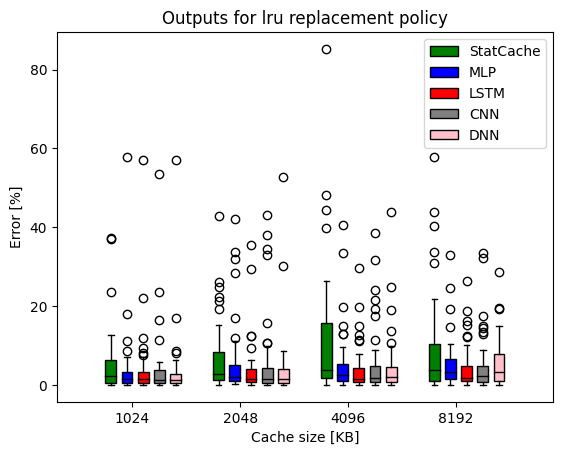

<Figure size 640x480 with 0 Axes>

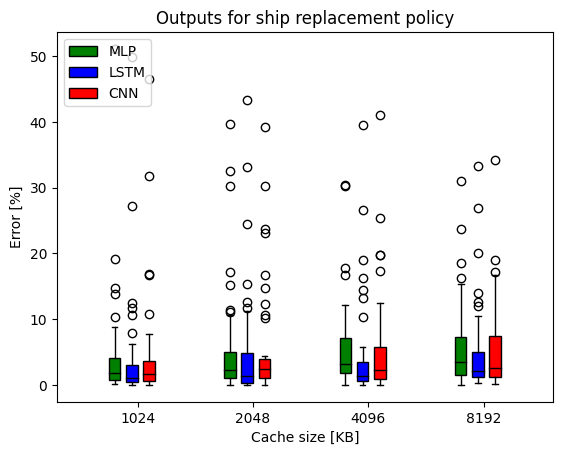

<Figure size 640x480 with 0 Axes>

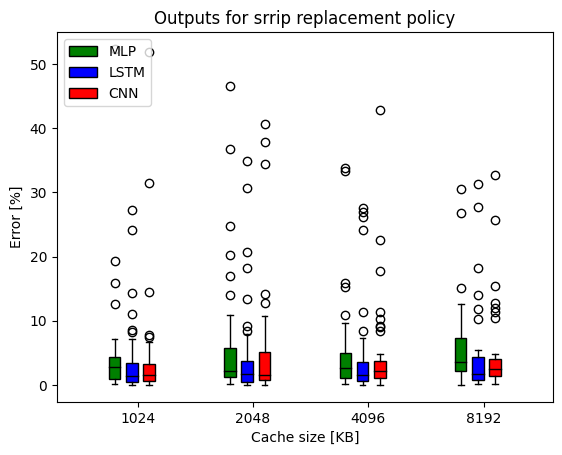

<Figure size 640x480 with 0 Axes>

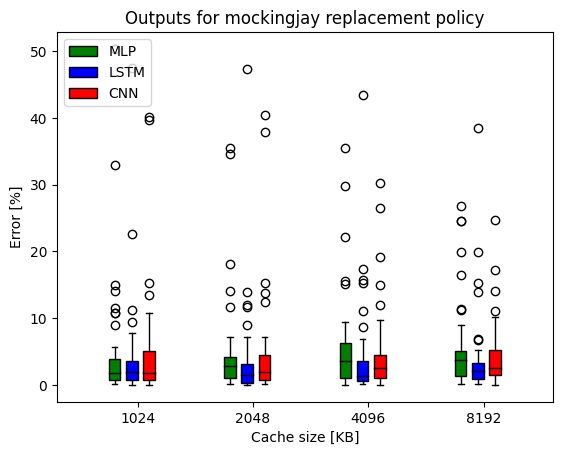

In [56]:
labels = ["lru", "ship", "srrip", "mockingjay"]
models = ["MLP", "LSTM", "CNN"]
for i in range(4):
    plt.figure()
    x = [big_boxplot_list[j][i] for j in range(3)]
    if i == 0:
        data = np.loadtxt('../cache_estimator/data.csv', delimiter=',')
        print(data.T.shape)
        x = [data.T] + x
        data = np.load('../Downloads/4_tmp.npy')
        # x = data.T
        print(data[1::2].shape)
        x = x + [data[1::2].T] 

    plt.figure()
    colors = ['green', 'blue', 'red', 'gray', 'pink']
    w = 0.1
    tmp = []
    for j in range(len(x)):
        a = plt.boxplot(x[j], positions=np.arange(4)+w*j*1.5, widths=w, 
                        patch_artist=True,
                        boxprops={'color': 'black', 'facecolor' : colors[j - (len(x)==4)] },
                        whiskerprops={'color': 'black'},
                        capprops={'color': 'black'},
                        flierprops={'markeredgecolor': 'black'},
                        medianprops={'color': 'black'}
                        )
        tmp.append(a)
    if len(x) == 3:
        plt.legend([tmp[0]["boxes"][0], tmp[1]["boxes"][0], tmp[2]["boxes"][0]], models, loc='upper left')
    else:
        plt.legend([tmp[0]["boxes"][0], tmp[1]["boxes"][0], tmp[2]["boxes"][0], tmp[3]["boxes"][0], tmp[4]["boxes"][0]], 
                   ["StatCache"] + models + ["DNN"], loc='upper right')
#         for box in a['boxes']:
#             box.set(facecolor = 'green' )
    plt.title('Outputs for '+labels[i] +' replacement policy')
    plt.xticks(np.arange(4) + 0.2, ['1024', '2048', '4096', '8192'])
    #plt.yticks(np.linspace(0,100,11))
    plt.ylabel('Error [%]')
    plt.xlabel('Cache size [KB]')
    plt.savefig(f'../Documents/nn_figures/{labels[i]}_cumulative_boxplot.png')
    plt.show()


<Figure size 640x480 with 0 Axes>

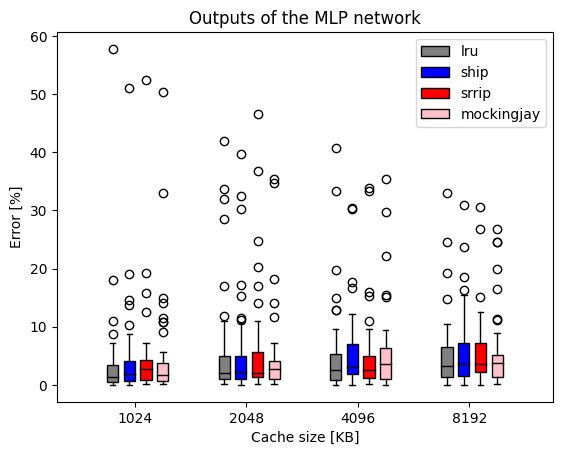

<Figure size 640x480 with 0 Axes>

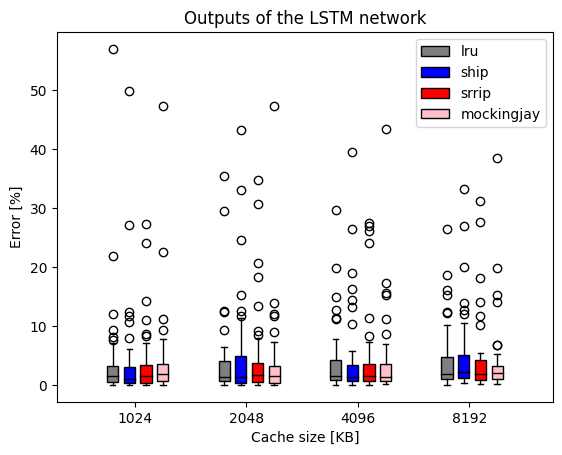

<Figure size 640x480 with 0 Axes>

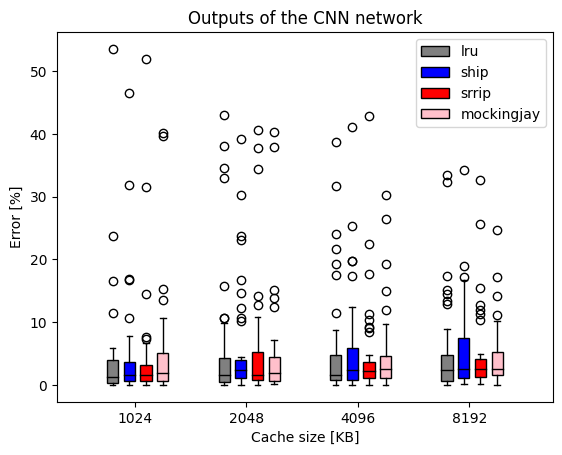

In [27]:
labels = ["lru", "ship", "srrip", "mockingjay"]
models = ["MLP", "LSTM", "CNN"]
for i in range(3):
    plt.figure()
    x = big_boxplot_list[i]
    plt.figure()
    colors = ['gray', 'blue', 'red', 'pink']
    w = 0.1
    tmp = []
    for j in range(4):
        a = plt.boxplot(x[j], positions=np.arange(4)+w*j*1.5, widths=w, 
                        patch_artist=True,
                        boxprops={'color': 'black', 'facecolor' : colors[j] },
                        whiskerprops={'color': 'black'},
                        capprops={'color': 'black'},
                        flierprops={'markeredgecolor': 'black'},
                        medianprops={'color': 'black'}
                        )
        tmp.append(a)
    plt.legend([tmp[0]["boxes"][0], tmp[1]["boxes"][0], tmp[2]["boxes"][0], tmp[3]["boxes"][0]], labels, loc='upper right')
#         for box in a['boxes']:
#             box.set(facecolor = 'green' )
    plt.title(f'Outputs of the {models[i]} network')
    plt.xticks(np.arange(4)+0.2, ['1024', '2048', '4096', '8192'])
#     plt.yticks(np.linspace(0,100,11))
    plt.ylabel('Error [%]')
    plt.xlabel('Cache size [KB]')
    plt.savefig(f'../Documents/nn_figures/{models[i]}_cumulative_boxplot.png')
    plt.show()

In [28]:
y = torch.load('../Documents/nn_outputs/mockinjay_test_y.pt')

In [29]:
print(y.mean(axis=0))

tensor([0.7402, 0.5942, 0.4531, 0.3433], dtype=torch.float64)


In [30]:
def read_files2(pred_path, test_path, col_path):
    x = torch.load(pred_path)
    y = torch.load(test_path)
    # print(mean_squared_error(x,y), x.shape)
    ids = pd.read_csv(col_path)
    d = []
    for i in range(len(x)):
        d.append(mean_squared_error(x[i],y[i]))
    ids['mse'] = d
    ids['1024'] = (x - y)
    ids['1024_abs'] = ids['1024'].abs()
    print(len(d))
    return ids

In [31]:
ids = read_files2(f'../Downloads/lru_other (9).pt',
                         f'../Downloads/test_y_other (1).pt', 
                         f'../Downloads/id_col_lru_other (1).csv')
create_plots(ids, fname, net)

ModuleNotFoundError: No module named 'tensorflow.python.framework.ops'

In [32]:
def calc_err(x, y, col_path, cols):
    ids = col_path
    ids['out'] = (x - y)
    
#     ids['out_abs'] = ids['1024'].abs()
    
    tmp = []
    ids['asp'] = [x.split('-')[0] for x in ids["file_name"]]
    for i in set(ids["column"]):
#         plt.figure()
#         print(ids[ids["column"]==i][ids["asp"]=='416.gamess'])
#         plt.hist(ids[ids["column"]==i][ids["asp"]=='416.gamess']['out'], np.linspace(-1,1,101))
#         plt.show()
        means = ids[ids["column"]==i].groupby('file_name')['out'].mean().to_frame()
        means['asp'] = [x.split('-')[0] for x in means.index]
        means['weights'] = [float(weights[x]) for x in means.index]
        #means['weights'] = means.groupby('asp')['weights'].apply(lambda x: x / x.sum())
        l = means.groupby('asp')['weights'].sum()
        means['sweights'] = [l[x] for x in means['asp']]
        means['weights'] = means['weights'] / means['sweights']
        means['out'] = means['out'] * means['weights']
        means = means.groupby('asp')['out'].mean().abs() # .apply(gmean) # apply(lambda x: x.max() - x.min())
        tmp.append(means)
#     print(i, gmean(means.abs()))
#     plt.figure()
#     plt.hist(means.abs(), np.linspace(0,1.0,101))
# #         plt.yticks([*range(0,int(plt.yticks()[0][-1]))])
#     plt.title('Histogram of predictions')
#     plt.ylabel('# benchmarks')
#     plt.xlabel('Error')
#     plt.show()
    plt.figure()
    plt.boxplot([x * 100 for x in tmp])
    plt.xticks([*range(1,len(cols)+1)], cols)
    string = 'Prediction, with input:' + ','.join([x for x in  ["768", "1024", "1536", "2048", "3072", "4096", "6144", "8192"] if x not in cols])
    plt.title(string + "KB")
    plt.ylabel('Error [%]')
    plt.xlabel('Cache size [KB]')
    plt.show(block=False)
    plt.savefig(f'../Documents/nn_figures/{len(cols)}_cols_boxplot.png')
    del ids
    return [gmean(x) for x in tmp]
# d = {
#     7:["768", "1024", "1536", "3072", "4096", "6144", "8192"],
#     6:["768", "1024", "1536", "3072", "4096", "6144"],
#     4:["768", "1536", "3072", "6144"],
#     2:["1536", "3072"],
#     1:["3072"]
# }
# for r in [1,2,4,6,7]:
#     y = torch.load(f'../Downloads/test_y_{r}_cols.pt')
#     x = torch.load(f'../Downloads/lru_changing_{r}_cols.pt')
#     ids = pd.read_csv(f'../Downloads/id_col_lru_other_{r}.csv')
#     cols = d[r]
#     f = calc_err(x, y, ids, cols)
#     for i,j in zip(f, cols):
#         print(f"Geometric mean for cache of size {j} KB: {i*100:.2f}%")

[[1.05001631e-01 8.66619632e-02 2.69217802e-02 4.63263478e-04
  4.37042976e-01 4.01396765e-02 1.25434798e-02 4.20134177e-02
  1.33313296e-01 3.44302513e-01 1.13844822e-02 2.82750265e-02
  1.36012053e-02 5.14045110e-01 3.24791534e-01 5.24299266e-03
  1.46670730e-02 8.63178220e-02 9.54712635e-03 9.18923861e-03
  1.27605308e-03 8.00733294e-02 2.15136653e-02 1.19778062e-01
  3.79562749e-02 9.97325239e-03 1.92429613e-02 3.89063506e-02
  3.88350040e-02 4.99229709e-02 1.70905943e-04 3.15280583e-02
  4.48336171e-02 1.01151329e-03 1.08651272e-01 3.75180309e-02
  5.21482705e-02 3.55765342e-02 9.45736999e-02 1.49274455e-02
  2.99452098e-02 5.01720181e-02 7.83057605e-02 1.24274875e-03
  1.61729534e-03 4.60045829e-03 5.13721942e-02]
 [8.07228337e-02 4.84290921e-02 5.53554964e-02 5.00352179e-04
  4.60270556e-01 3.40503111e-02 1.30757568e-02 9.36884291e-02
  1.09802629e-01 3.31633968e-01 9.10861503e-03 2.20105161e-02
  3.54078365e-02 4.70860088e-01 3.09678549e-01 5.78535813e-03
  7.16011532e-04 6.788

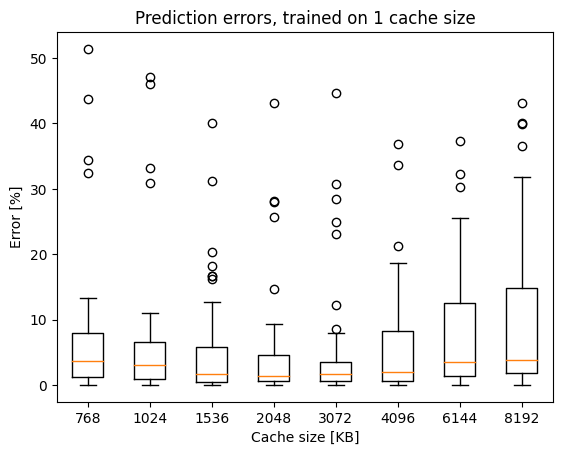

2.5\% & 2.0\% & 1.4\% & 1.3\% & 1.4\% & 1.9\% & 2.9\% & 4.0\% 
[[1.92476750e-02 6.31305773e-02 9.87928810e-03 3.61514103e-02
  4.97155512e-01 1.53695771e-02 2.95920599e-03 5.90070865e-02
  9.18892706e-02 2.09748061e-02 1.59580845e-04 1.87150649e-02
  2.96246899e-02 4.95181508e-02 2.03416429e-01 1.68270907e-02
  1.89133273e-02 1.11169720e-01 2.72080134e-03 2.46645901e-03
  3.24073696e-04 5.81554263e-02 1.48452359e-02 1.48795204e-02
  1.99165812e-02 6.76524724e-03 2.08107886e-03 1.48456010e-02
  9.22853888e-02 2.54912188e-02 4.26095450e-03 2.06124691e-02
  4.71009957e-02 3.23440068e-03 2.11537648e-02 1.36000395e-02
  1.72460833e-02 2.87531705e-02 8.69172713e-02 6.55976521e-02
  3.41922446e-02 3.67883135e-02 5.18103192e-02 9.12154954e-05
  3.97921746e-04 1.89952174e-03 3.94727032e-02]
 [8.52174240e-03 3.03335433e-02 8.33807339e-02 3.84831550e-02
  5.17737123e-01 1.18788341e-02 3.22922373e-03 1.80955627e-01
  7.17299973e-02 2.44860689e-02 1.92972350e-03 1.25413374e-02
  7.07334336e-03 5.00

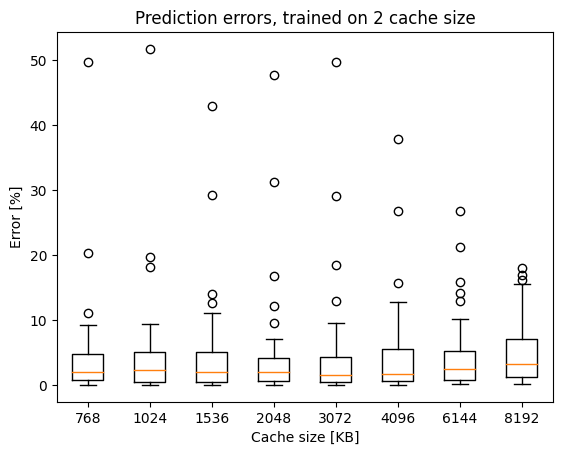

1.5\% & 1.4\% & 1.3\% & 1.4\% & 1.3\% & 1.5\% & 2.0\% & 2.4\% 
[[6.33430278e-02 3.26666712e-02 6.62950971e-03 1.78608229e-02
  5.72397495e-01 3.61870057e-03 4.02390547e-03 1.65104931e-04
  6.95048602e-02 1.35290364e-02 9.05871948e-04 2.02335800e-02
  3.90125160e-03 3.30395825e-02 5.89567279e-02 9.52478443e-03
  2.98609017e-02 5.87365738e-02 1.16366554e-02 9.29041338e-05
  9.95309092e-04 3.52223834e-02 1.23479419e-02 1.61439340e-02
  1.83139743e-02 1.99819403e-02 3.79875322e-04 2.09664983e-02
  3.35040027e-02 3.27224631e-02 1.35474279e-03 8.29790659e-03
  1.91928390e-02 3.88378097e-03 2.12166984e-02 2.68860728e-03
  5.84649195e-03 1.45936611e-02 1.14429868e-01 1.35388388e-02
  3.26121367e-03 2.74708967e-02 3.91543567e-02 5.28252547e-05
  1.80441256e-03 1.87944278e-03 1.60662567e-02]
 [5.05101060e-02 7.08711222e-03 5.55232794e-02 1.97527193e-02
  5.94600114e-01 1.07164206e-03 4.41160697e-03 1.19042554e-01
  5.15518745e-02 1.62975615e-02 2.56299571e-03 1.43122167e-02
  1.72985829e-02 1.85

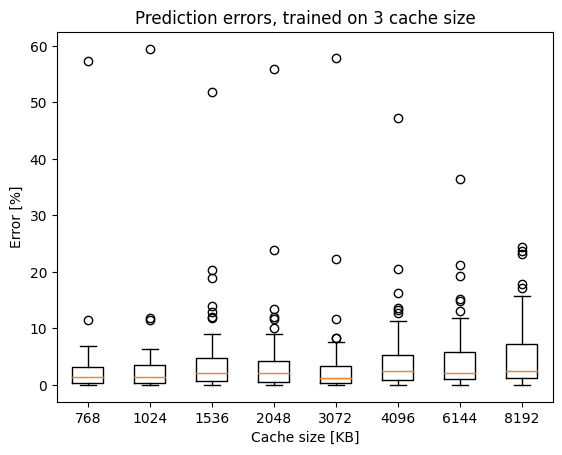

0.9\% & 1.0\% & 1.7\% & 1.5\% & 1.2\% & 1.9\% & 2.0\% & 2.6\% 
[[3.11154111e-02 5.81944870e-03 1.38534455e-02 1.96839469e-02
  5.50090993e-01 5.71393597e-03 1.28145344e-03 4.84371347e-02
  1.91434739e-02 1.60298813e-02 2.53447577e-03 5.43639005e-03
  3.19144667e-02 4.31130804e-02 2.66623953e-02 1.55142001e-02
  3.52270180e-02 5.41156893e-02 4.47220129e-03 1.26306740e-03
  2.66957733e-03 8.67826791e-03 1.00233249e-02 1.48272684e-02
  4.58027804e-03 1.13470177e-02 1.00314001e-03 2.36489810e-02
  1.48056964e-02 1.06264204e-02 3.12766673e-03 2.28534321e-03
  7.06222682e-02 4.87997918e-03 2.22813276e-02 8.14052456e-03
  1.49322237e-02 1.33873512e-02 4.81508260e-02 2.52899514e-02
  6.75443039e-02 3.61478901e-02 2.29140592e-02 4.85845729e-04
  3.31591790e-03 1.15878551e-03 2.21938633e-02]
 [2.26556407e-02 8.39291382e-03 8.64904859e-02 2.21045323e-02
  5.69974336e-01 2.55859439e-03 1.51025755e-03 1.70284489e-01
  3.65217450e-03 1.95383725e-02 4.16900249e-03 1.10426483e-02
  1.06384323e-02 6.44

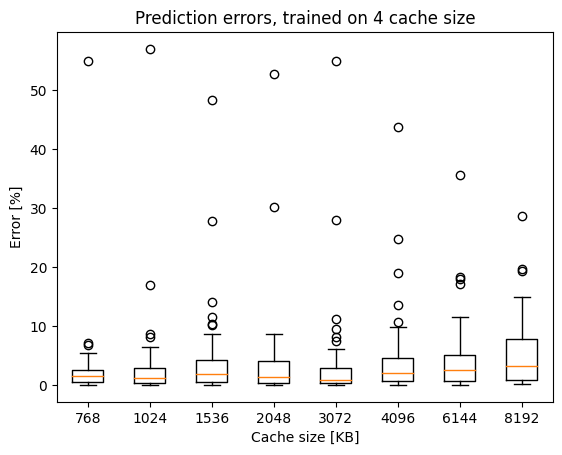

1.1\% & 1.1\% & 1.5\% & 1.2\% & 0.9\% & 1.8\% & 2.1\% & 2.4\% 
[[3.87494710e-03 1.90625331e-03 9.88934618e-03 1.30101315e-02
  3.14794982e-01 1.90500618e-03 3.73812754e-03 1.01431456e-01
  3.07237334e-02 8.54147032e-04 2.25217849e-03 2.68870176e-02
  2.32347190e-02 3.69290836e-02 4.36742953e-02 5.88851421e-02
  2.60615337e-02 2.25455511e-02 4.65472591e-03 3.01747447e-03
  4.99389190e-04 2.89479252e-03 1.98131769e-02 2.05589692e-02
  1.04241271e-02 8.15269025e-03 3.87528802e-04 3.72629486e-04
  2.64214705e-02 6.14427589e-04 2.46585795e-03 3.59787605e-03
  5.50075198e-02 4.52735613e-03 2.75386914e-02 4.87295016e-04
  8.27044312e-03 1.65347415e-02 7.38924840e-02 2.18648328e-02
  3.13406489e-02 9.98025463e-03 2.18089162e-02 1.40932090e-03
  1.50647783e-03 7.87487106e-04 2.97841860e-03]
 [8.43952459e-03 5.38157521e-03 7.82126733e-02 1.46547714e-02
  3.29569074e-01 4.80159672e-04 4.15701736e-03 2.21675613e-01
  1.73344984e-02 1.56481747e-03 3.79468919e-03 2.14935679e-02
  5.12970683e-03 9.32

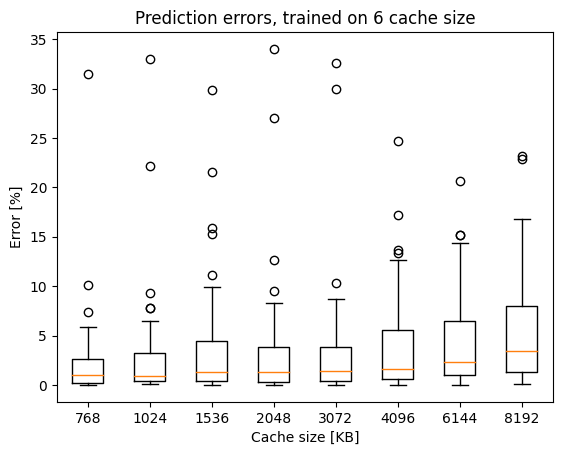

0.8\% & 1.0\% & 1.3\% & 1.0\% & 1.2\% & 1.6\% & 2.2\% & 2.9\% 


In [54]:
def calc_err(x, y, col_path, cols, input_cols):
    ids = col_path
    ids['out'] = (x - y)
    
#     ids['out_abs'] = ids['1024'].abs()
    
    tmp = []
    ids['asp'] = [x.split('-')[0] for x in ids["file_name"]]
    for i in set(ids["column"]):
        means = ids[ids["column"]==i].groupby('file_name')['out'].mean().to_frame()
        means['asp'] = [x.split('-')[0] for x in means.index]
        means['weights'] = [float(weights[x]) for x in means.index]
        #means['weights'] = means.groupby('asp')['weights'].apply(lambda x: x / x.sum())
        l = means.groupby('asp')['weights'].sum()
        means['sweights'] = [l[x] for x in means['asp']]
        means['weights'] = means['weights'] / means['sweights']
        means['out'] = means['out'] * means['weights']
        means = means.groupby('asp')['out'].mean().abs() # .apply(gmean) # apply(lambda x: x.max() - x.min())
#         means = means[means.index != '416.gamess']
#         print(means)
        tmp.append(means)
    plt.figure()
    plt.boxplot([x * 100 for x in tmp])
    plt.xticks([*range(1,len(cols)+1)], cols)
    plt.title('Prediction errors, trained on ' + input_cols + ' cache size')
    plt.ylabel('Error [%]')
    plt.xlabel('Cache size [KB]')
    plt.savefig(f'../Documents/nn_figures/{input_cols}_unknown_boxplot.png')
    print(np.array(tmp))
    # Used in the previous cell to print all 5 columns
    np.save(f'../Downloads/{input_cols}_tmp', np.array(tmp) * 100)
    plt.show()
    del ids
    return [gmean(x)*100 for x in tmp]
for i in [1,2,3,4,6]:
    x = np.load(f'../Documents/nn_outputs2/dnn_preds_{i}.npy')
    y = np.load(f'../Documents/nn_outputs2/dnn_test_y_{i}.npy')
    ids = np.load(f'../Documents/nn_outputs2/dnn_names_{i}.npy', allow_pickle=True)
    ids = pd.DataFrame(ids, columns = ['window_name', 'file_name', 'benchmark', 'column'])
    # print(ids)
    s = calc_err(x, y, ids, ["768", "1024", "1536", "2048", "3072", "4096", "6144", "8192"], str(i))
    print(f"{s[0]:.1f}\\% & {s[1]:.1f}\\% & {s[2]:.1f}\\% & {s[3]:.1f}\\% & {s[4]:.1f}\\% & {s[5]:.1f}\\% & {s[6]:.1f}\\% & {s[7]:.1f}\\% ")

In [ ]:
i=3
x = np.load(f'../Downloads/dnn_preds_{i} (1).npy')
y = np.load(f'../Downloads/dnn_test_y_{i} (1).npy')
ids = np.load(f'../Downloads/dnn_names_{i} (1).npy', allow_pickle=True)
ids = pd.DataFrame(ids, columns = ['window_name', 'file_name', 'benchmark', 'column'])
# print(ids)
s = calc_err(x, y, ids, ["768", "1024", "1536", "2048", "3072", "4096", "6144", "8192"], str(i))
print(f"{s[0]:.1f}\\% & {s[1]:.1f}\\% & {s[2]:.1f}\\% & {s[3]:.1f}\\% & {s[4]:.1f}\\% & {s[5]:.1f}\\% & {s[6]:.1f}\\% & {s[7]:.1f}\\% ")